In [1]:
import xarray as xr

In [2]:
ds = xr.open_dataset("../output/grids/a3d_grids.nc")
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 19)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-01-01T19:00:00
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    snow_density           (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    USTAR                  (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    VW_DRIFT               (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2020-07-27
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-07-27T22:53:28Z, erke2265@shas0125.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

In [3]:
var='SURF_ALB'
ds[var]

<xarray.DataArray 'SURF_ALB' (time: 19, northing: 107, easting: 168)>
[341544 values with dtype=float32]
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-01-01T19:00:00
  * northing  (northing) float32 -109000.0 -108000.0 ... -4000.0 -3000.0
  * easting   (easting) float32 -1542000.0 -1541000.0 ... -1376000.0 -1375000.0

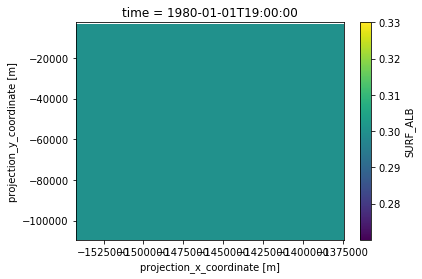

In [5]:
ds[var][-1,:,:].plot()

In [5]:
ds[var][0,,0]

<xarray.DataArray 'SURF_ALB' ()>
array(0.3, dtype=float32)
Coordinates:
    time      datetime64[ns] 1980-01-01T01:00:00
    northing  float32 -109000.0
    easting   float32 -1542000.0